# Developing new Imputation Methods

We work on an example dataset which is automatically downloaded from the pride database

In [12]:
from pyproteonet.io.datasets import load_example_dataset
from pyproteonet.processing import logarithmize

ds = load_example_dataset()
# wo work on logarithmized values
ds = logarithmize(ds)
# we do our own peptide-to-protein aggregation to have control over the process
from pyproteonet.aggregation import maxlfq
_ = maxlfq(dataset=ds, molecule='protein_group', mapping='peptide-protein_group', partner_column='intensity',
           min_ratios=2, median_fallback=False, result_column='intensity')

# For evaluation purposes we also introduce some artificial missing values
from pyproteonet.simulation import simulate_mcars
ds.values['peptide']['intensity_gt'] = ds.values['peptide']['intensity']
ds.values['protein_group']['intensity_gt'] = ds.values['protein_group']['intensity']
simulate_mcars(dataset=ds, molecule='peptide', column='intensity', amount=0.1, inplace=True)
# a second aggregation is required to get the new protein intensities including new missing values
_ = maxlfq(dataset=ds, molecule='protein_group', mapping='peptide-protein_group', partner_column='intensity',
           min_ratios=2, median_fallback=False, result_column='intensity')

/hpi/fs00/home/tobias.pietz/MasterThesis/pyproteonet/pyproteonet/aggregation/maxlfq.py:186: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  grouping = mask_group(groupings[group_idx])


## Developing Imputation Methods Working on One Molecule Type

Most such methods can be easiest applied to pandas dataframes which can be extracted from a dataset.
For example the ```.get_wf(...)``` function returns a dataframe in wide format, the ```.get_lf(...)``` return a long format DataFrame.

So the general strategy for implementing a new imputation method is to get the values for the molecule and value column to be imputed as pandas DataFrame, then apply the imputation method and finally return the result or write it back to the dataset.

It is advisable to implement new imputtion methods as function with a signature similar to already existing imputation methods (see example below).
In addition it is convention that an imputation methods return the imputation result as pandas Series in long format.

Here is an easy example replacing any molecule with >50% missing values with the sample mean an any other molecule with the sample 10% percentile 

In [13]:
from typing import Optional
import numpy as np
import pandas as pd
from pyproteonet.data import Dataset
from pyproteonet.imputation.random_forest import random_forest_impute

def simple_imputation(ds: Dataset, molecule: str, column:str, result_column: Optional[str] = None)->pd.Series:
    wf = ds.get_wf(molecule=molecule, column=column)
    # create imputed DataFrame
    wf_imputed = wf.copy()
    wf_imputed[wf.isna().sum(axis=1) > wf.shape[1] / 2] = wf.quantile(0.1)
    wf_imputed[wf.isna().sum(axis=1) <= wf.shape[1] / 2] = wf.mean()
    # only impute missing values
    mask = wf.isna()
    wf[mask] = wf_imputed[mask]
    if result_column:
        ds.set_wf(matrix=wf, molecule=molecule, column=result_column)
    # not strictly required but within PyProteoNet it is good practice to return the imputed values in long format
    res = wf.stack()
    res.index.set_names(['id', 'sample'], inplace=True)
    return res

Now, applying the imputation is as easy as calling the function:

In [15]:
imp = simple_imputation(ds, molecule='peptide', column='intensity', result_column='simple_imputed')

Below another more example implementing a new imputation methods that uses MissForest imputation for all molecules with <=50% missing samples the 10% quantile abundance values is used for the remaining molecules.

In [16]:
def mixed_imputation(ds: Dataset, molecule: str, column:str, result_column: Optional[str] = None)->pd.Series:
    # get the original abundance values in long format (pandas DataFrame with MultiIndex with molecule id and sample)
    lf_missing = ds.get_lf(molecule=molecule)[column]
    # first impute the missing values using a random forest (MissForest), by convention this returns the result as pandas Series in long format.
    lf_imputed = random_forest_impute(ds, molecule=molecule, column=column)
    # get the 10% percentile value
    imp_value = lf_missing.quantile(0.1)
    # get all molecules with more than 50% missing values by grouping by molecule id and replace their missing values with the 10% percentile
    mask_molecules = lf_missing.isna().groupby('id').sum()
    mask_molecules = mask_molecules[mask_molecules / ds.num_samples > 0.5].index
    # get the index of the missing values belonging to molecules with 
    mask = lf_missing[lf_missing.index.get_level_values('id').isin(mask_molecules)]
    mask = mask[mask.isna()].index
    # set the missing values to the 10% percentile
    lf_imputed.loc[mask] = imp_value
    # if a result column is given, write the imputed values back to the dataset
    if result_column:
        ds.set_column_lf(molecule=molecule, values=lf_imputed, column=result_column)
    return lf_imputed

In [17]:
imp2 = mixed_imputation(ds, molecule='peptide', column='intensity', result_column='combined_imputed')

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9


In [18]:
ds.get_lf(molecule='peptide')

intensity  intensity_gt  simple_imputed  combined_imputed
sample  id                                                             
1_hu_c1 0           NaN        18.249          17.035            18.336
        1           NaN           NaN          17.035            17.289
        2        17.855        17.855          17.855            17.855
        3           NaN        17.009          17.035            17.168
        4           NaN           NaN          15.378            15.439
...                 ...           ...             ...               ...
6_hu_p3 8141     16.057        16.057          16.057            16.057
        8142        NaN           NaN          15.510            15.439
        8143     17.591        17.591          17.591            17.591
        8144     17.566        17.566          17.566            17.566
        8145     19.875        19.875          19.875            19.875

[48876 rows x 4 columns]

Once developed it is straight forward to apply the imputation methods on every molecule type we like

In [19]:
imp = simple_imputation(ds, molecule='protein_group', column='intensity', result_column='simple_imputed')
imp2 = mixed_imputation(ds, molecule='protein_group', column='intensity', result_column='combined_imputed')

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


## Developing Imputation Methods Based on (Graph) Neural Networks

For demonstration purpose we develop a simple graph neural network (GNN) jointly operating on the intensity values of protein_group and peptide. This shows some of the functionality of PyProteoNet that can be used to develop neural network based imputation methods.

First we create a dataset out of our original dataset only containing the relevant molecules and values (in our case the intensity value column).  This can be done using the ```.copy(...)``` function provided by Datasets.

In addtion GNN values should be standardized to have zero mean and unit variance. The PyProteoNet dataset standardizer can be used for this. Next to standardizing values it also stores the standardization parameters so that predictions can be transformed back later on.

In [20]:
from pyproteonet.processing import Standardizer

gnn_ds = ds.copy(columns={'peptide':'intensity', 'protein_group':'intensity'})
standardizer = Standardizer(columns=['intensity'])
gnn_ds = standardizer.standardize(gnn_ds)

For training a GNN in a self supervised fashion we want to mask some non-missing values then used to train the GNN. For this reason PyProteoNet provides ```MaskedDataset``` which wraps a dataset but also specifies which values to mask (and/or hide) per molecule type to "simulate" missing values for self-supervised training. 
For more robust results it is advisable to not keep the masked nodes static but use different masked sets during trainig.
Therefore, we can use a ```MaskedDatasetGenerator``` in combination with a custom generator function.
Here we randomly mask 40% of peptides and all of the protein_groups (to enforce the GNN to learn aggregation peptide values into protein values).

In [21]:
from pyproteonet.masking import MaskedDataset, MaskedDatasetGenerator
# Defining our custom masking function.
def masking_fn(in_ds):
    pep_ids = in_ds.values['peptide']["intensity"]
    # sample 30% of non-missing peptides
    pep_ids = pep_ids[~pep_ids.isna()].sample(frac=0.3).index
    # mask all non-missing protein groups
    prot_ids = in_ds.values['protein_group']["intensity"]
    prot_ids = prot_ids[~prot_ids.isna()].index
    return MaskedDataset.from_ids(dataset=in_ds, mask_ids={'protein_group': prot_ids, 'peptide': pep_ids},)

# Create a masked dataset generator with 10 randomly masked datasets per epoch
mask_ds = MaskedDatasetGenerator(datasets=[gnn_ds], generator_fn=masking_fn, epoch_size_multiplier=50)

In addition we need to transform our Dataset/MaskedDatasets into tensors suitable for inputting into a neural network. PyProteoNet, therefore, provides the ```to_dgl_graph(..)``` function to transform a Dataset or MaskedDataset into a DLG graph which can either be used directly as input into a GNN or used to extract specific tensors.

Here we define a simple collate function transforming a batch of MaskedDatasets into a heterogeneous DGL graph. Therefore, we first transform each MaskedDataset into a heterogeneous DGL graph using PyProteoNet's ```.to_dgl_graph(...)``` function and, subsequently, merge all graph into a single graph using DGL's standard collate function.

It should be noted that the collate function gets a batch of MaskedDatasets and a list of samples for each MaskedDataset in the list. This allows sample wise training. However, here we just transform the whole Dataset into a single graph containing all samples 

In [22]:
from dgl.dataloading import GraphCollator
collator = GraphCollator()
def collate(masked_datasets_and_samples):
    res = []
    for md, samples in masked_datasets_and_samples:
        # create a DGL graph from the masked dataset containing binary masks indicating the masked and hidden nodes
        graph = md.to_dgl_graph(
            feature_columns={
                'protein_group': 'intensity',
                'peptide': 'intensity',
            },
            mappings=['peptide-protein_group'],
            make_bidirectional=True,
            samples=samples,
        )
        res.append(graph)
    return collator.collate(res)

The only thing left to do ist to define the GNN architecture. We do this in the form of a Lightning Module.

In [45]:
import torch
from torch import nn
import lightning as L
from dgl.nn.pytorch.conv import GATv2Conv
from dgl.nn.pytorch import HeteroGraphConv
from dgl.dataloading import GraphCollator

class ImputationModule(L.LightningModule):
    def __init__(self, num_samples: int, num_proteins: int):
        super().__init__()
        # Four fully connected layers applied on the peptide input across samples
        lat_dim = 4
        self.pep_fully_connected = nn.Sequential(nn.Linear(num_samples, num_samples), nn.LeakyReLU(),
                                                 nn.Linear(num_samples, num_samples), nn.LeakyReLU(),
                                                 nn.Linear(num_samples, lat_dim), nn.LeakyReLU(),
                                                 nn.Linear(lat_dim, num_samples), nn.LeakyReLU())
        # Learnable protein embedding
        self.prot_embedding = nn.Embedding(num_proteins, lat_dim)
        # Two GATv2 layers for utilizing the protein-peptides relations
        self.prot_gat = HeteroGraphConv({'peptide-protein_group': GATv2Conv(in_feats=(num_samples, lat_dim), out_feats=num_samples, num_heads=32,)})
        self.pep_gat = HeteroGraphConv({'peptide-protein_group': GATv2Conv(in_feats=(num_samples + lat_dim, num_samples), out_feats=num_samples, num_heads=32,)})
        self.prot_final_linear = nn.Linear(num_samples + lat_dim, num_samples)
        self.pep_final_linear = nn.Linear(num_samples + num_samples, num_samples)
        # value to use for missing and masked abundance values
        self.mask_value = -3

    def forward(self, graph):
        abundance = graph.ndata["intensity"]
        # mask hidden nodes
        hidden = graph.ndata["hidden"]
        for key, hide in hidden.items():
            abundance[key][hide] = self.mask_value
        # mask masked nodes
        masks = graph.ndata["mask"]
        for key, mask in masks.items():
            abundance[key][mask] = self.mask_value
        # replace missing values with mask value
        for key, ab in abundance.items():
            ab[torch.isnan(ab)] = self.mask_value
        # applying the input fully connected layers
        pep_latent = self.pep_fully_connected(abundance['peptide'])
        # applying the protein embedding
        prot_latent = self.prot_embedding(graph.nodes('protein_group').int())
        # applying the GATv2 layers, averaging the output over the nodes, and applying LeakyReLU as activation function
        prot_vec = nn.functional.leaky_relu(self.prot_gat(graph, ({'peptide':pep_latent}, {'protein_group':prot_latent}))['protein_group']).mean(dim=-2)
        # "skip connection" by concatenating the protein embedding and the GATv2 output
        prot_vec = torch.cat([prot_vec, prot_latent], dim=-1)
        pep_vec = nn.functional.leaky_relu(self.pep_gat(graph, ({'protein_group':prot_vec}, {'peptide':pep_latent}))['peptide']).mean(dim=-2)
         # "skip connection" by concatenating the peptide latent reprensentation and the GATv2 output
        pep_vec = torch.cat([pep_vec, pep_latent], dim=-1)
        # concatenate the peptide input and the GATv2 output
        # applying the final linear layer for both proteins and peptides
        prot_vec, pep_vec = self.prot_final_linear(prot_vec), self.pep_final_linear(pep_vec)
        return prot_vec, pep_vec

    def compute_loss(self, graph) -> torch.tensor:
        # we only compute the loss on masked nodes
        abundance = graph.ndata["intensity"]
        masks = graph.ndata["mask"]
        # store gt for later loss computation
        prot_gt = abundance['protein_group'][masks['protein_group']].detach().clone()
        pep_gt = abundance['peptide'][masks['peptide']].detach().clone()
        # forward pass
        prot_vec, pep_vec = self(graph)
        # compute loss
        prot_pred = prot_vec[masks['protein_group']]
        pep_pred = pep_vec[masks['peptide']]
        prot_loss = nn.functional.mse_loss(prot_pred, prot_gt) 
        pep_loss = nn.functional.mse_loss(pep_pred, pep_gt)
        self.log("prot_loss", prot_loss.item(), on_step=False, on_epoch=True, batch_size=1)
        self.log("pep_loss", pep_loss.item(), on_step=False, on_epoch=True, batch_size=1)
        loss = prot_loss + pep_loss
        self.log("loss", loss.item(), on_step=False, on_epoch=True, batch_size=1)
        return loss

    def training_step(self, graph, batch_idx):
        loss = self.compute_loss(graph)
        return loss

    def predict_step(self, graph, batch_idx, dataloader_idx=0):
        prot_vec, pep_vec = self(graph)
        return prot_vec, pep_vec

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

Finally, we can train our GNN using Lightning

In [46]:
from torch.utils.data import DataLoader
from pyproteonet.lightning import ConsoleLogger
from pyproteonet.lightning.training_early_stopping import TrainingEarlyStopping

model = ImputationModule(num_samples=ds.num_samples, num_proteins=ds.molecules['protein_group'].shape[0])
# For fast prototyping PyProteoNet provides a simple logger printing the logs, however, you can use any Lightnign logger you like (e.g. log to TensorBoard etc.)
logger = ConsoleLogger()
trainer = L.Trainer(
    logger=logger,
    log_every_n_steps=1,
    check_val_every_n_epoch=1,
    max_epochs=1000,
    enable_checkpointing=False,
    # Due to our self-supervised training scheme we use early stopping based on the training loss
    callbacks=[TrainingEarlyStopping(monitor="loss", mode="min", patience=5)],
)
train_dl = DataLoader(mask_ds, batch_size=1, collate_fn=collate)
trainer.fit(model=model, train_dataloaders=train_dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type            | Params
--------------------------------------------------------
0 | pep_fully_connected | Sequential      | 142   
1 | prot_embedding      | Embedding       | 7.3 K 
2 | prot_gat            | HeteroGraphConv | 2.5 K 
3 | pep_gat             | HeteroGraphConv | 3.6 K 
4 | prot_final_linear   | Linear          | 66    
5 | pep_final_linear    | Linear          | 78    
--------------------------------------------------------
13.8 K    Trainable params
0         Non-trainable params
13.8 K    Total params
0.055     Total estimated model params size (MB)


Training: |                                                                                                   …

step49: prot_loss:1.825 || pep_loss:0.831 || loss:2.656 || epoch:0.000 || 
step99: prot_loss:1.666 || pep_loss:0.753 || loss:2.419 || epoch:1.000 || 
step149: prot_loss:1.391 || pep_loss:0.698 || loss:2.089 || epoch:2.000 || 
step199: prot_loss:0.957 || pep_loss:0.609 || loss:1.566 || epoch:3.000 || 
step249: prot_loss:0.700 || pep_loss:0.482 || loss:1.182 || epoch:4.000 || 
step299: prot_loss:0.540 || pep_loss:0.401 || loss:0.941 || epoch:5.000 || 
step349: prot_loss:0.408 || pep_loss:0.365 || loss:0.773 || epoch:6.000 || 
step399: prot_loss:0.348 || pep_loss:0.345 || loss:0.692 || epoch:7.000 || 
step449: prot_loss:0.313 || pep_loss:0.332 || loss:0.645 || epoch:8.000 || 
step499: prot_loss:0.288 || pep_loss:0.319 || loss:0.607 || epoch:9.000 || 
step549: prot_loss:0.271 || pep_loss:0.309 || loss:0.580 || epoch:10.000 || 
step599: prot_loss:0.256 || pep_loss:0.300 || loss:0.556 || epoch:11.000 || 
step649: prot_loss:0.239 || pep_loss:0.291 || loss:0.530 || epoch:12.000 || 
step699: pr

The last thing to do is to predict the genuine missing values using the trained GNN and transform the results back into the original dataset

In [47]:
# Generate a dataset all missing values masked because those are the values we want to predict/impute
missing_prots = ds.values['protein_group']['intensity']
missing_prots = missing_prots[missing_prots.isna()].index
missing_peps = ds.values['peptide']['intensity']
missing_peps = missing_peps[missing_peps.isna()].index
missing_mds = MaskedDataset.from_ids(dataset=gnn_ds, mask_ids={'protein_group': missing_prots, 'peptide': missing_peps})
pred_dl = DataLoader([(missing_mds, ds.sample_names)], batch_size=1, collate_fn=collate)
prot_pred, pep_pred = trainer.predict(model=model, dataloaders=pred_dl)[0]

# Write the imputed values back to the MaskedDataset and the underlying gnn_ds dataset (We only write back to the masked/missing values)
missing_mds.set_samples_value_matrix(matrix=prot_pred, molecule='protein_group', column="intensity", only_set_masked=True)
missing_mds.set_samples_value_matrix(matrix=pep_pred, molecule='peptide', column="intensity", only_set_masked=True)

# Undo the standardization to tranform the imputed values back to the original scale
res_ds = standardizer.unstandardize(gnn_ds)

# Set the result to our original dataset
ds.values['protein_group']['gnn_imp'] = res_ds.values['protein_group']['intensity']
ds.values['peptide']['gnn_imp'] = res_ds.values['peptide']['intensity']

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                                 …

In [48]:
ds.values['peptide'].df

intensity  intensity_gt  simple_imputed  combined_imputed  \
sample  id                                                                
1_hu_c1 0           NaN        18.249          17.035            18.336   
        1           NaN           NaN          17.035            17.289   
        2        17.855        17.855          17.855            17.855   
        3           NaN        17.009          17.035            17.168   
        4           NaN           NaN          15.378            15.439   
...                 ...           ...             ...               ...   
6_hu_p3 8141     16.057        16.057          16.057            16.057   
        8142        NaN           NaN          15.510            15.439   
        8143     17.591        17.591          17.591            17.591   
        8144     17.566        17.566          17.566            17.566   
        8145     19.875        19.875          19.875            19.875   

              gnn_imp  
sample  id             
1_hu_c1 0      18.569  
        1      17.476  
        2      17.855  
        3      16.124  
        4      15.813  
...               ...  
6_hu_p3 8141   16.057  
        8142   16.832  
        8143   17.591  
        8144   17.566  
        8145   19.875  

[48876 rows x 5 columns]

Finally, lets do a quick evaluation on the artificially introduced missing values by comparing the imputed values to the ground truth values both on the protein as well as the peptide level.

<Axes: xlabel='column', ylabel='metric'>

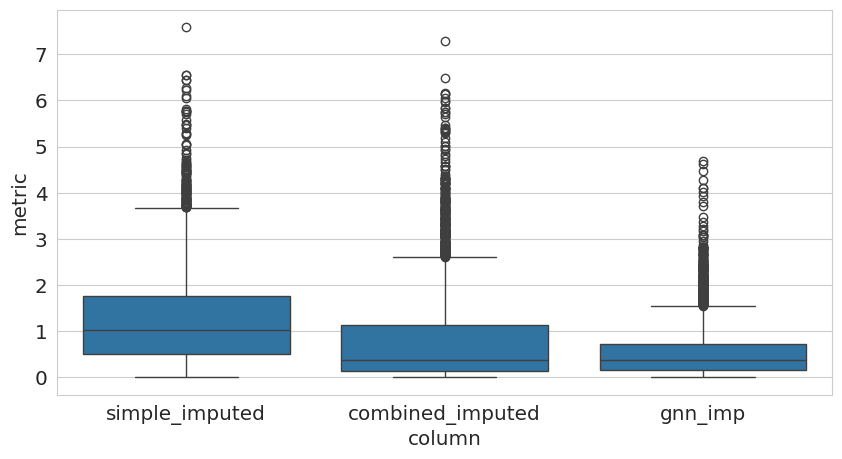

In [49]:
from pyproteonet.metrics.abundance_comparison import compare_columns
from matplotlib import pyplot as plt
from seaborn import boxplot
ids = ds.values['peptide']['intensity_gt']
ids = ids[~ids.isna() & ds.values['peptide']['intensity'].isna()].index
metric_df = compare_columns(dataset=ds, molecule='peptide', columns=['simple_imputed', 'combined_imputed', 'gnn_imp'], comparison_column='intensity_gt',
                            metric='AE', logarithmize=False, ids=ids)
fig, ax = plt.subplots(1, figsize=(10, 5))
boxplot(data=metric_df, x='column', y='metric')

<Axes: xlabel='column', ylabel='metric'>

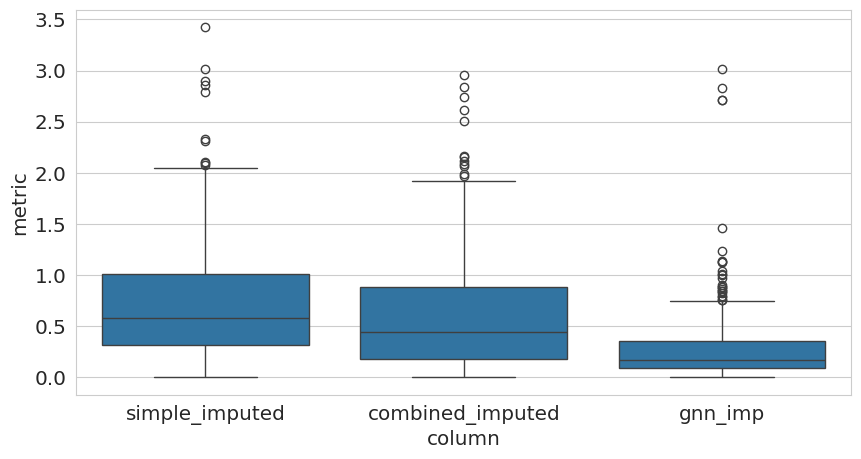

In [50]:
ids = ds.values['peptide']['intensity_gt']
ids = ids[~ids.isna() & ds.values['protein_group']['intensity'].isna()].index
metric_df = compare_columns(dataset=ds, molecule='protein_group', columns=['simple_imputed', 'combined_imputed', 'gnn_imp'], comparison_column='intensity_gt',
                            metric='AE', logarithmize=False, ids=ids)
fig, ax = plt.subplots(1, figsize=(10, 5))
boxplot(data=metric_df, x='column', y='metric')